# Method5 DCT based DOST + RLE

## Import Libraries

In [1]:
import numpy as np
from scipy.fft import fft,fftshift
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from scipy import signal
from scipy.fftpack import fft, dct, idct
from itertools import islice 
import pandas as pd
import os

## Preprocessing

### Data loading

In [2]:
acc = pd.read_csv('ACC.csv')
acc = acc.iloc[1:]
acc.columns = ['column1','column2','column3']
np.savetxt('acc.txt',acc)



acc_c1 = acc["column1"]
acc_c2 = acc["column2"]
acc_c3 = acc["column3"]
acc_array_c1 = acc_c1.to_numpy() #save the data into an ndarray
acc_array_c2 = acc_c2.to_numpy()
acc_array_c3 = acc_c3.to_numpy()
acc_array_c1.shape

acc_array_c1 = acc_array_c1[0:66000]  # Remove the signal in first 3minutes and last 5minutes
acc_array_c2 = acc_array_c2[0:66000]
acc_array_c3 = acc_array_c3[0:66000]

sampling_freq = 1/32
N = acc_array_c1.size

xf = np.linspace(-N*sampling_freq/2, N*sampling_freq/2,  N)


index = np.linspace(0, round((N-1)*sampling_freq,4), N)

### Butterworth Filter to denoise 

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

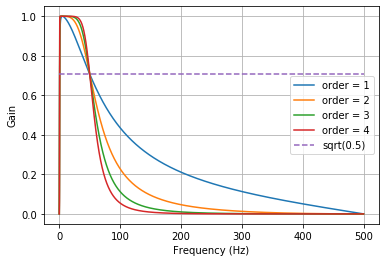

In [4]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 0.5
highcut = 50.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

In [5]:
y1 = butter_bandpass_filter(acc_array_c1, lowcut, highcut, fs, order=2)
y2 = butter_bandpass_filter(acc_array_c2, lowcut, highcut, fs, order=2)
y3 = butter_bandpass_filter(acc_array_c3, lowcut, highcut, fs, order=2)

In [6]:
resampled_signal1 = y1
resampled_signal2 = y2
resampled_signal3 = y3

In [7]:
np.savetxt('processed_acc_col1.txt',resampled_signal1)
np.savetxt('processed_acc_col2.txt',resampled_signal2)
np.savetxt('processed_acc_col3.txt',resampled_signal3)

In [8]:
rounded_signal1 = np.around(resampled_signal1)
rounded_signal2 = np.around(resampled_signal2)
rounded_signal3 = np.around(resampled_signal3)

## Transformation --- DCT based DOST 

In [9]:
aN1 = dct(rounded_signal1, type = 2, norm = 'ortho')
aN2 = dct(rounded_signal2, type = 2, norm = 'ortho')
aN3 = dct(rounded_signal3, type = 2, norm = 'ortho')

In [10]:
def return_N(target):
    if target > 1:
        for i in range(1, int(target)):
            if (2 ** i >= target):
                return i-1
    else:
        return 1


In [11]:
split_list = [1]
for i in range(0,return_N(aN1.size)):
    split_list.append(2 ** i)
temp1 = iter(aN1) 
res1 = [list(islice(temp1, 0, ele)) for ele in split_list]
temp2 = iter(aN2) 
res2 = [list(islice(temp2, 0, ele)) for ele in split_list]
temp3 = iter(aN3) 
res3 = [list(islice(temp3, 0, ele)) for ele in split_list]

In [12]:
cN_idct1 = [list(idct(res1[0], type = 2, norm = 'ortho' )), list(idct(res1[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res1)):
    cN_idct1.append(list(idct(res1[k], type = 2, norm = 'ortho' )))
cN_idct2 = [list(idct(res2[0], type = 2, norm = 'ortho' )), list(idct(res2[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res2)):
    cN_idct2.append(list(idct(res2[k], type = 2, norm = 'ortho' )))
cN_idct3 = [list(idct(res3[0], type = 2, norm = 'ortho' )), list(idct(res3[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res3)):
    cN_idct3.append(list(idct(res3[k], type = 2, norm = 'ortho' )))

In [13]:
all_numbers1 = []
for i in cN_idct1:
    for j in i:
        all_numbers1.append(j)
all_numbers2 = []
for i in cN_idct2:
    for j in i:
        all_numbers2.append(j)
all_numbers3 = []
for i in cN_idct3:
    for j in i:
        all_numbers3.append(j)

In [14]:
all_numbers1 = np.asarray(all_numbers1)
all_numbers2 = np.asarray(all_numbers2)
all_numbers3 = np.asarray(all_numbers3)

In [15]:
int_cN1 = np.round(all_numbers1,3)
int_cN2 = np.round(all_numbers2,3)
int_cN3 = np.round(all_numbers3,3)

## Run-length Encoding

In [16]:
def RLE(input_data):
    RLE_VALUE = []
    RLE_FREQ = []
    count = 0
    for i in range(0,len(input_data)):
        if i == len(input_data)-1:
            if input_data[i] != input_data[i-1]:
                RLE_VALUE.append(input_data[i])
                RLE_FREQ.append(1)
                return RLE_VALUE, RLE_FREQ
            else:
                return RLE_VALUE, RLE_FREQ
        else:
            if input_data[i] == input_data[i+1]:
                count += 1
                    
                
            else:
                RLE_VALUE.append(input_data[i])
                count += 1
                RLE_FREQ.append(count)
                count = 0


In [17]:
value1, freq1 = RLE(int_cN1)
value2, freq2 = RLE(int_cN2)
value3, freq3 = RLE(int_cN3)

In [18]:
np.savetxt('acc1_value_rle.txt',value1, fmt='%.3f')
np.savetxt('acc1_freq_rle.txt',freq1, fmt='%.3f')
np.savetxt('acc2_value_rle.txt',value2, fmt='%.3f')
np.savetxt('acc2_freq_rle.txt',freq2, fmt='%.3f')
np.savetxt('acc3_value_rle.txt',value3, fmt='%.3f')
np.savetxt('acc3_freq_rle.txt',freq3, fmt='%.3f')

## Reconstruction

In [19]:
decoded_data1_rle_value = np.loadtxt(fname = "acc1_value_rle.txt")
decoded_data1_rle_freq = np.loadtxt(fname = "acc1_freq_rle.txt")
decoded_data2_rle_value = np.loadtxt(fname = "acc2_value_rle.txt")
decoded_data2_rle_freq = np.loadtxt(fname = "acc2_freq_rle.txt")
decoded_data3_rle_value = np.loadtxt(fname = "acc3_value_rle.txt")
decoded_data3_rle_freq = np.loadtxt(fname = "acc3_freq_rle.txt")

In [20]:
decoded_data1_rle_freq = decoded_data1_rle_freq.astype(int)
recover_signal1 = []
for i in range(len(decoded_data1_rle_value)):
    for k in range(decoded_data1_rle_freq[i]):
        recover_signal1.append(decoded_data1_rle_value[i])  
decoded_data2_rle_freq = decoded_data2_rle_freq.astype(int)
recover_signal2 = []
for i in range(len(decoded_data2_rle_value)):
    for k in range(decoded_data2_rle_freq[i]):
        recover_signal2.append(decoded_data2_rle_value[i])  
decoded_data3_rle_freq = decoded_data3_rle_freq.astype(int)
recover_signal3 = []
for i in range(len(decoded_data3_rle_value)):
    for k in range(decoded_data3_rle_freq[i]):
        recover_signal3.append(decoded_data3_rle_value[i])  

In [21]:
recover_signal1 = list(recover_signal1)
recover_signal2 = list(recover_signal2)
recover_signal3 = list(recover_signal3)

In [22]:
split_list = [1]
for i in range(0,return_N(len(recover_signal1))+1):
    split_list.append(2 ** i)
temp_recovered1 = iter(recover_signal1) 
res_recovered1 = [list(islice(temp_recovered1, 0, ele)) for ele in split_list]
temp_recovered2 = iter(recover_signal2) 
res_recovered2 = [list(islice(temp_recovered2, 0, ele)) for ele in split_list] 
temp_recovered3 = iter(recover_signal3) 
res_recovered3 = [list(islice(temp_recovered3, 0, ele)) for ele in split_list] 

In [23]:
recover_dct1 = [list(dct(res_recovered1[0], type = 2, norm = 'ortho' )), list(dct(res_recovered1[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res_recovered1)):
    recover_dct1.append(list(dct(res_recovered1[k], type = 2, norm = 'ortho' )))
recover_dct2 = [list(dct(res_recovered2[0], type = 2, norm = 'ortho' )), list(dct(res_recovered2[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res_recovered2)):
    recover_dct2.append(list(dct(res_recovered2[k], type = 2, norm = 'ortho' )))
recover_dct3 = [list(dct(res_recovered3[0], type = 2, norm = 'ortho' )), list(dct(res_recovered3[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res_recovered3)):
    recover_dct3.append(list(dct(res_recovered3[k], type = 2, norm = 'ortho' )))

In [24]:
all_recover1 = []
for i in recover_dct1:
    for j in i:
        all_recover1.append(j)
all_recover2 = []
for i in recover_dct2:
    for j in i:
        all_recover2.append(j)
all_recover3 = []
for i in recover_dct3:
    for j in i:
        all_recover3.append(j)


In [25]:
aN_recover1 = idct(all_recover1, type = 2, norm = 'ortho')
aN_recover2 = idct(all_recover2, type = 2, norm = 'ortho')
aN_recover3 = idct(all_recover3, type = 2, norm = 'ortho')

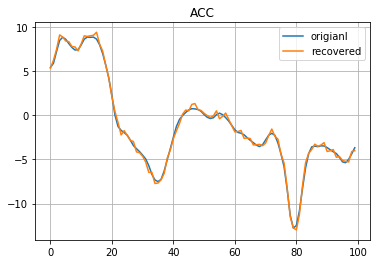

In [26]:
plt.plot(signal.resample(y1, len(aN_recover1))[31000:31100], label = "origianl")
plt.plot(aN_recover1[31000:31100], label = "recovered")
plt.legend()
plt.title('ACC')
plt.grid()
plt.show()

In [27]:
#resampled_signal_shorter = resampled_signal1[:len(aN_recover1)] 
resampled_signal_shorter1 = signal.resample(y1, len(aN_recover1))
from sklearn.metrics import mean_squared_error
from math import sqrt

def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(resampled_signal_shorter1, aN_recover1)
print("The PRD is {}%".format(round(PRD*100,3)))

The PRD is 3.345%
